In [51]:
import h5py
import pandas as pd
from pathlib import Path
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.signal

In [ ]:
''' GOAL PART1: having a big unique csv file with data from all the videos 

to do that we need to: 
OK- read the hdf5 files
OK- store information in the right coloumn and add missing coloums for each h5 file 
coloumns we want are: 
        fly id (exp,arena,maze) -> get it from the directory with command inputpath.parent.name
        frame (called index) -> already there, to be extracted
        X and Y coordinates of head, abdomen, thorax -> already there, to be extracted
        time (in seconds) -> compute it (29 frames per sec)
        starving status  -> depends on experiment 
        habituation status -> depends on arena number
    area (blu_obj, oran_obj, neutral) -> need to define thresholds either with gimpy or with the pixel thing (see notes on word) 

- join all files together 
- save csv file 

'''

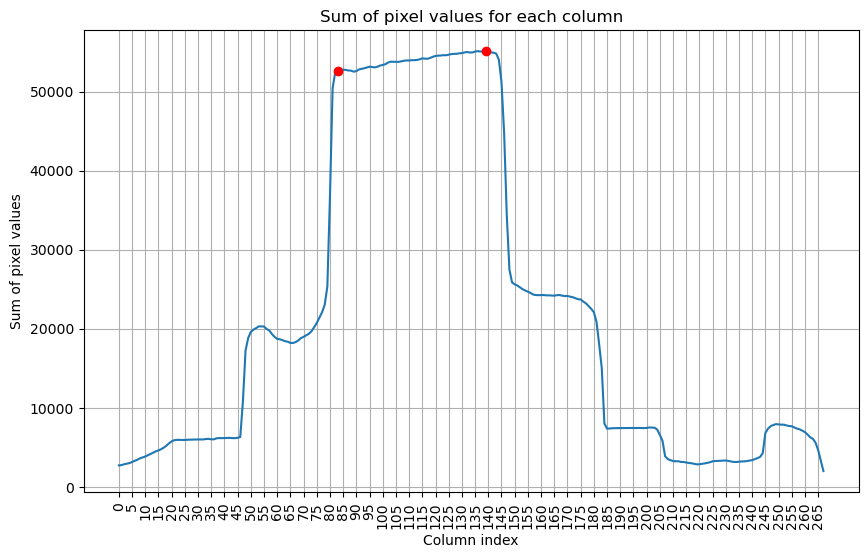

[ 83 139]


In [92]:
#here for each maze in each experiment we define a threshold pixel value for the area of the maze (blue, orange, neutral)

# List all mp4 files in the directory and subdirectories
input = Path("c:/Users/win/Desktop/Alice_Samara_Videos2") #CHANGE PATH HERE
videos = list(input.rglob("*.mp4"))

# Get the first frame of each video 
for video in videos:
    cap = cv2.VideoCapture(video.as_posix())
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    ret, frame = cap.read()
    cap.release()

    # Convert the image to grayscale if it's not already
    if len(frame.shape) == 3:  # Check if the image has color channels
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Calculate the sum of pixel values for each column (x-coordinate)
    column_pixel_sums = np.sum(frame, axis=0)

    # Create an array of x-coordinates
    x_values = np.arange(len(column_pixel_sums))

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the pixel sums
    ax.plot(x_values, column_pixel_sums)

    # Add a grid
    ax.grid(True)

    # Set the x-ticks with an interval of 5
    ax.set_xticks(np.arange(min(x_values), max(x_values)+1, 5))

# Rotate x-axis labels
    plt.xticks(rotation=90)

    # Set the labels and title
    ax.set_xlabel('Column index')
    ax.set_ylabel('Sum of pixel values')
    ax.set_title('Sum of pixel values for each column')

    # Find peaks with a minimum distance of 55
    column_pixel_sums_1d = column_pixel_sums.flatten()
    peaks, properties = scipy.signal.find_peaks(column_pixel_sums_1d, height = (30_000, 70_000), distance=55)

    #it returns the indices of peaks in column_pixel_sums_1d that satisfy all given conditions
    #properties is a dictionary containing properties of the peaks and we are interested in the height of them

    # Get the heights of the peaks
    peak_heights = properties['peak_heights']

    # Sort the peaks by their heights in descending order and get the indices of the two highest peaks
    highest_peaks_indices = np.argsort(peak_heights)[-2:]

    # Get the x values of the two highest peaks
    highest_peaks_x_values = peaks[highest_peaks_indices]
    
    #plot red dots on the 2 highest peaks on the graph
    ax.plot(highest_peaks_x_values, column_pixel_sums[highest_peaks_x_values], 'ro')
    # Show the plot
    plt.show()

    #store the x values of the two highest peaks in a list that varies depending on the experiment, the arena and the maze (data contained in the video variable)
    #the list will be used to define the thresholds for the area of the maze in the next cell
    #the list is called thresholds
    




In [91]:
highest_peaks_x_values


array([ 83, 139], dtype=int64)

In [38]:
# List all h5 files in the directory and subdirectories
input = Path("c:/Users/win/Desktop/Alice_Samara_Videos2") #CHANGE PATH HERE
h5_files = list(input.rglob("*.h5"))
#h5_files #to print and see if it works

#cycle to run the code for each video related h5 file in all the paths where it found some 

for testpath in h5_files:
    #get node names and locs matrix with all info
    with h5py.File(testpath.as_posix(), "r") as f:
                dset_names = list(f.keys())
                locs = f["tracks"][:].T #this has the coordinates of the nodes (x,y)
                node_names = [n.decode() for n in f["node_names"][:]]
            #LEGEND: locs[0] refers to the first frame
            #locs [0][0] first frame, abdomen (1 = thorax, 2 = head)
            #locs [0][0][0] first frame, abdomen, x value (1 = y value)
            #locs 
    #get all locations for all the frames of a video divided by body part 
    HEAD_INDEX = 2
    THORAX_INDEX = 1
    ABDO_INDEX = 0
    head_loc = locs[:, HEAD_INDEX, :, :]
    thorax_loc = locs[:, THORAX_INDEX, :, :]
    abdo_loc = locs[:, ABDO_INDEX, :, :]
    
    #build a dataframe with locations of different body parts divided by x and y (flatten to remove a parenthesis and save them in df)
    df = pd.DataFrame(
        {
            "head_x": head_loc[:, 0].flatten(),
            "head_y": head_loc[:, 1].flatten(),
            "thorax_x": thorax_loc[:, 0].flatten(),
            "thorax_y": thorax_loc[:, 1].flatten(),
            "abdo_x": abdo_loc[:, 0].flatten(),
            "abdo_y": abdo_loc[:, 1].flatten(),
        }
    ).reset_index()
#df.head() to print and see how it looks like

#now we add the missing columns to the dataframe

#time (in seconds) of each frame considering that we have 29 frames for second
seconds_per_frame = 1/29
df["time"] = df["index"]*seconds_per_frame    

#fly ids (exp,arena,maze)
#take the fly id from the directory name
#find the experiment/arena/maze number in the path knowing that it is always next to the word experiment/arena/maze
path = testpath.parent.parent.name
df["arena"] = re.search(r'arena(\d+)', path).group(1)
path = testpath.parent.name
df["maze"] = re.search(r'maze(\d+)', path).group(1)
path = testpath.parent.parent.parent.name
df["exp"] = re.search(r'experiment(\d+)', path).group(1)

#starving status (starved in experiment2, experiment5 fed in experiment1, experiment3, experiment4 )
fed_conditions = ("mazes_experiment2_Videos", "mazes_experiment3_Videos")
df["starving_cond"] = df["exp"].apply(lambda x: "starved" if any(cond in x for cond in fed_conditions) else "fed")

#habituation status (unused if arena0, arena1, arena2, blue if arena3, arena4, arena5, orange if arena6, arena7, arena8)
blue_arenas = ("arena3", "arena4", "arena5")
orange_arenas = ("arena6", "arena7", "arena8")
df["habituation_cond"] = df["arena"].apply(lambda x: "blue" if any(cond in x for cond in blue_arenas) else "orange" if any(cond in x for cond in orange_arenas) else "unused")

#area (blu_obj, oran_obj, neutral) -> need to define thresholds either with gimpy or with the pixel thing (see notes on word)
# we calculate the sum of pixels in each coloumn of each frame




In [30]:
column_pixel_sums


array([[ 2712,  2712,  2712],
       [ 2750,  2750,  2750],
       [ 2856,  2856,  2856],
       [ 2924,  2924,  2924],
       [ 3000,  3000,  3000],
       [ 3144,  3144,  3144],
       [ 3285,  3285,  3285],
       [ 3431,  3431,  3431],
       [ 3606,  3606,  3606],
       [ 3723,  3723,  3723],
       [ 3835,  3835,  3835],
       [ 3993,  3993,  3993],
       [ 4147,  4147,  4147],
       [ 4320,  4320,  4320],
       [ 4489,  4489,  4489],
       [ 4609,  4609,  4609],
       [ 4760,  4760,  4760],
       [ 4953,  4953,  4953],
       [ 5204,  5204,  5204],
       [ 5502,  5502,  5502],
       [ 5751,  5751,  5751],
       [ 5900,  5900,  5900],
       [ 5938,  5938,  5938],
       [ 5941,  5941,  5941],
       [ 5926,  5926,  5926],
       [ 5930,  5930,  5930],
       [ 5951,  5951,  5951],
       [ 5967,  5967,  5967],
       [ 5978,  5978,  5978],
       [ 5985,  5985,  5985],
       [ 5984,  5984,  5984],
       [ 5985,  5985,  5985],
       [ 5996,  5996,  5996],
       [ 6

In [29]:
h5_files

[WindowsPath('c:/Users/win/Desktop/Alice_Samara_Videos2/mazes_experiment2_Videos/arena2/maze0/maze0_tracked_fly.000_maze0.analysis.h5')]

In [11]:
df.head()


,index,head_x,head_y,thorax_x,thorax_y,abdo_x,abdo_y,time,arena,maze,exp,starving_cond,habituation_cond
0,0,61.347015,401.748993,67.705666,415.448242,74.194603,434.220245,0.000000,2,0,2,fed,unused
1,1,61.354038,402.226410,67.652405,418.227142,74.065765,434.681793,0.034483,2,0,2,fed,unused
2,2,61.402702,402.344116,67.743828,418.335236,74.219925,434.780640,0.068966,2,0,2,fed,unused
3,3,61.692535,402.465088,68.000687,418.487793,74.380882,437.303619,0.103448,2,0,2,fed,unused
4,4,61.681725,402.463684,67.995590,418.485779,74.379990,437.299133,0.137931,2,0,2,fed,unused


In [16]:
locs

array([[[[ 74.19460297],
         [434.22024536]],

        [[ 67.70566559],
         [415.44824219]],

        [[ 61.34701538],
         [401.74899292]]],


       [[[ 74.06576538],
         [434.68179321]],

        [[ 67.65240479],
         [418.22714233]],

        [[ 61.35403824],
         [402.22640991]]],


       [[[ 74.21992493],
         [434.78063965]],

        [[ 67.74382782],
         [418.3352356 ]],

        [[ 61.40270233],
         [402.34411621]]],


       ...,


       [[[151.70970154],
         [ 35.60498428]],

        [[170.41453552],
         [ 41.77960205]],

        [[186.53562927],
         [ 45.24257278]]],


       [[[151.81039429],
         [ 35.59921646]],

        [[170.37174988],
         [ 41.91687393]],

        [[184.07774353],
         [ 45.65935516]]],


       [[[154.47328186],
         [ 35.64250183]],

        [[170.81877136],
         [ 42.03455353]],

        [[186.8349762 ],
         [ 45.85036469]]]])

In [ ]:
videopath.parent.name

'maze0'

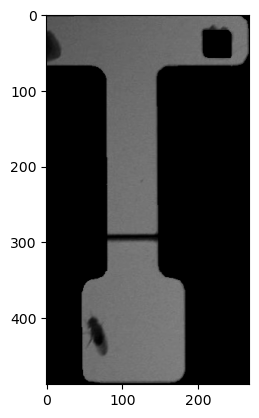

In [ ]:
# Get first frame
import cv2
cap = cv2.VideoCapture(videopath.as_posix())
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = cap.read()
cap.release()

# Display first frame
import matplotlib.pyplot as plt
plt.imshow(frame)

In [ ]:
# Get abdomen location

abdomen = locs[0][1]

abdomen

array([[ 67.70566559],
       [415.44824219]])

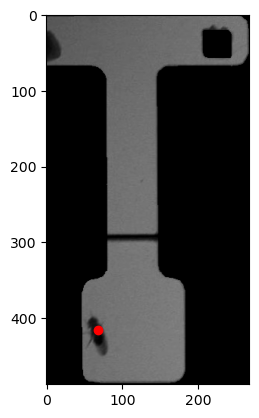

In [ ]:
# Add abdomen to frame
plt.imshow(frame)
plt.scatter(abdomen[0], abdomen[1], c="red")

In [ ]:
# Get all head locations

heads = locs[2]

heads

array([[[ 74.21992493],
        [434.78063965]],

       [[ 67.74382782],
        [418.3352356 ]],

       [[ 61.40270233],
        [402.34411621]]])

In [ ]:
locs.T

array([[[[ 74.19460297,  74.06576538,  74.21992493, ..., 151.70970154,
          151.81039429, 154.47328186],
         [ 67.70566559,  67.65240479,  67.74382782, ..., 170.41453552,
          170.37174988, 170.81877136],
         [ 61.34701538,  61.35403824,  61.40270233, ..., 186.53562927,
          184.07774353, 186.8349762 ]],

        [[434.22024536, 434.68179321, 434.78063965, ...,  35.60498428,
           35.59921646,  35.64250183],
         [415.44824219, 418.22714233, 418.3352356 , ...,  41.77960205,
           41.91687393,  42.03455353],
         [401.74899292, 402.22640991, 402.34411621, ...,  45.24257278,
           45.65935516,  45.85036469]]]])

In [ ]:
HEAD_INDEX = 2
THORAX_INDEX = 1
ABDO_INDEX = 0

head_loc = locs[:, HEAD_INDEX, :, :]
thorax_loc = locs[:, THORAX_INDEX, :, :]
abdo_loc = locs[:, ABDO_INDEX, :, :]

In [ ]:
abdo_loc

array([[[ 74.19460297],
        [434.22024536]],

       [[ 74.06576538],
        [434.68179321]],

       [[ 74.21992493],
        [434.78063965]],

       ...,

       [[151.70970154],
        [ 35.60498428]],

       [[151.81039429],
        [ 35.59921646]],

       [[154.47328186],
        [ 35.64250183]]])

In [ ]:


head_loc[:, 0].flatten()

array([ 61.34701538,  61.35403824,  61.40270233, ..., 186.53562927,
       184.07774353, 186.8349762 ])

In [ ]:
# Build DataFrame with all locations

df = pd.DataFrame(
    {
        "head_x": head_loc[:, 0].flatten(),
        "head_y": head_loc[:, 1].flatten(),
        "thorax_x": thorax_loc[:, 0].flatten(),
        "thorax_y": thorax_loc[:, 1].flatten(),
        "abdo_x": abdo_loc[:, 0].flatten(),
        "abdo_y": abdo_loc[:, 1].flatten(),
    }
).reset_index()

In [ ]:
df.head()

,index,head_x,head_y,thorax_x,thorax_y,abdo_x,abdo_y
0,0,61.347015,401.748993,67.705666,415.448242,74.194603,434.220245
1,1,61.354038,402.226410,67.652405,418.227142,74.065765,434.681793
2,2,61.402702,402.344116,67.743828,418.335236,74.219925,434.780640
3,3,61.692535,402.465088,68.000687,418.487793,74.380882,437.303619
4,4,61.681725,402.463684,67.995590,418.485779,74.379990,437.299133


In [ ]:
left = df[df["head_x"] < 60]

left

,index,head_x,head_y,thorax_x,thorax_y,abdo_x,abdo_y
10,10,58.698372,412.033386,70.837486,425.094940,80.644501,441.165314
11,11,58.443439,415.082489,70.728043,428.020203,80.945946,443.796875
12,12,55.330021,418.407562,68.243958,430.853668,81.323944,443.739899
13,13,55.264500,421.596558,70.699409,431.269531,84.190163,443.546783
14,14,55.328918,424.462311,70.866776,433.833771,84.542061,443.517456
...,...,...,...,...,...,...,...
104024,104024,52.238312,9.656157,51.528286,25.820482,48.721085,42.432072
104025,104025,52.142834,7.021115,48.834251,23.380489,45.822773,42.274895
104026,104026,52.113541,7.037872,48.754635,23.394806,45.753239,42.291096
104027,104027,58.255943,9.922314,51.742435,25.886534,45.479565,42.182716


In [ ]:
df["left"] = df["head_x"] < 60

In [ ]:
df

,index,head_x,head_y,thorax_x,thorax_y,abdo_x,abdo_y,left
0,0,61.347015,401.748993,67.705666,415.448242,74.194603,434.220245,False
1,1,61.354038,402.226410,67.652405,418.227142,74.065765,434.681793,False
2,2,61.402702,402.344116,67.743828,418.335236,74.219925,434.780640,False
3,3,61.692535,402.465088,68.000687,418.487793,74.380882,437.303619,False
4,4,61.681725,402.463684,67.995590,418.485779,74.379990,437.299133,False
...,...,...,...,...,...,...,...,...
104397,104397,187.000290,41.978241,170.786148,38.929581,151.956467,35.765343,False
104398,104398,186.660507,42.183510,170.483459,39.035282,151.666779,35.604900,False
104399,104399,186.535629,45.242573,170.414536,41.779602,151.709702,35.604984,False
104400,104400,184.077744,45.659355,170.371750,41.916874,151.810394,35.599216,False


In [ ]:
# Add "area" column to DataFrame that is "Left" if head is left of the screen and "Right" otherwise

df["area"] = "Middle"

df.loc[df["head_x"] < 60, "area"] = "Left"

df.loc[df["head_x"] > 150, "area"] = "Right"
df

,index,head_x,head_y,thorax_x,thorax_y,abdo_x,abdo_y,left,area
0,0,61.347015,401.748993,67.705666,415.448242,74.194603,434.220245,False,Middle
1,1,61.354038,402.226410,67.652405,418.227142,74.065765,434.681793,False,Middle
2,2,61.402702,402.344116,67.743828,418.335236,74.219925,434.780640,False,Middle
3,3,61.692535,402.465088,68.000687,418.487793,74.380882,437.303619,False,Middle
4,4,61.681725,402.463684,67.995590,418.485779,74.379990,437.299133,False,Middle
...,...,...,...,...,...,...,...,...,...
104397,104397,187.000290,41.978241,170.786148,38.929581,151.956467,35.765343,False,Right
104398,104398,186.660507,42.183510,170.483459,39.035282,151.666779,35.604900,False,Right
104399,104399,186.535629,45.242573,170.414536,41.779602,151.709702,35.604984,False,Right
104400,104400,184.077744,45.659355,170.371750,41.916874,151.810394,35.599216,False,Right


In [ ]:
df["name"] = "fly"

df

,index,head_x,head_y,thorax_x,thorax_y,abdo_x,abdo_y,left,area,name
0,0,61.347015,401.748993,67.705666,415.448242,74.194603,434.220245,False,Middle,fly
1,1,61.354038,402.226410,67.652405,418.227142,74.065765,434.681793,False,Middle,fly
2,2,61.402702,402.344116,67.743828,418.335236,74.219925,434.780640,False,Middle,fly
3,3,61.692535,402.465088,68.000687,418.487793,74.380882,437.303619,False,Middle,fly
4,4,61.681725,402.463684,67.995590,418.485779,74.379990,437.299133,False,Middle,fly
...,...,...,...,...,...,...,...,...,...,...
104397,104397,187.000290,41.978241,170.786148,38.929581,151.956467,35.765343,False,Right,fly
104398,104398,186.660507,42.183510,170.483459,39.035282,151.666779,35.604900,False,Right,fly
104399,104399,186.535629,45.242573,170.414536,41.779602,151.709702,35.604984,False,Right,fly
104400,104400,184.077744,45.659355,170.371750,41.916874,151.810394,35.599216,False,Right,fly


In [ ]:
# Save DataFrame to CSV
df.to_csv("fly.csv", index=False)

In [ ]:
Datasets = []

Datasets.append(df)
Datasets.append(df)
Datasets.append(df)



In [ ]:
#concatemate df
Data = pd.concat(Datasets)

In [ ]:
Data

,index,head_x,head_y,thorax_x,thorax_y,abdo_x,abdo_y,left,area,name
0,0,61.347015,401.748993,67.705666,415.448242,74.194603,434.220245,False,Middle,fly
1,1,61.354038,402.226410,67.652405,418.227142,74.065765,434.681793,False,Middle,fly
2,2,61.402702,402.344116,67.743828,418.335236,74.219925,434.780640,False,Middle,fly
3,3,61.692535,402.465088,68.000687,418.487793,74.380882,437.303619,False,Middle,fly
4,4,61.681725,402.463684,67.995590,418.485779,74.379990,437.299133,False,Middle,fly
...,...,...,...,...,...,...,...,...,...,...
104397,104397,187.000290,41.978241,170.786148,38.929581,151.956467,35.765343,False,Right,fly
104398,104398,186.660507,42.183510,170.483459,39.035282,151.666779,35.604900,False,Right,fly
104399,104399,186.535629,45.242573,170.414536,41.779602,151.709702,35.604984,False,Right,fly
104400,104400,184.077744,45.659355,170.371750,41.916874,151.810394,35.599216,False,Right,fly
